# Task: Есть ли взаимосвязь между размером мозга и интеллектом 

Usefull links
    - http://www.scipy-lectures.org/packages/statistics/index.html
    - http://lib.stat.cmu.edu/DASL/Datafiles/Brainsize.html 
    - https://www.youtube.com/watch?v=Po5LkYaIQpo&list=PLlb7e2G7aSpRG_Ve6kuxc9Biuwyf42kJx&index=7

$$\rho(\xi,\eta)=\frac{\mathrm{Cov}(\xi, \eta)}{\sigma_\xi\sigma_\eta}$$

$$r_{X,Y}=\frac{\frac{1}{n}\sum_{i=1}^{n}(X_i-\bar{X})(Y_i-\bar{Y})}{S_XS_Y}$$
$$S_X^2=\frac{1}{n}\sum_{i=1}^{n}(X_i-\bar{X})^2, S_Y^2=\frac{1}{n}\sum_{i=1}^{n}(Y_i-\bar{Y})^2$$

$r_{X,Y}\sqrt{n-2}/\sqrt{1-r_{X,Y}^2}$ - Подчиняется распределению Стюдента с n-2 степенями свободы

# Libs

In [1]:
import pandas as pd
from scipy import stats
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np

# Data loading and simple EDA

Исходные данные были добавлены в Excel-таблицу и затем инициализированы как DataFrame с помощью библиотеки pandas

In [30]:
df_raw = pd.read_excel('HW1_T4_brain_size_data.xlsx')

С целью найти выбросы построим графики boxplot для интересующих нас переменных (размер мозга и интеллект) без разделения на группы по интеллекту. Переменные PIQ и VIQ не рассматриваются, так как из них составляется переменная FSIQ. А переменные Weight и Height не рассматриваются, так как по заданию надо исследовать корреляцию именно между размером мозга и интеллектом.

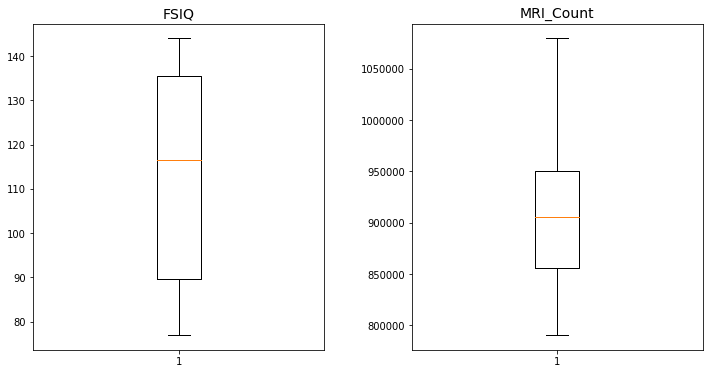

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fs = 14

variables = ['FSIQ', 'MRI_Count']

for col in range(2):
    variable = variables[col]
    axes[col].boxplot(df_raw[variable])
    axes[col].set_title(variable, fontsize=fs)

fig.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

Выбросы отсутствуют. Однако проверить их стоит также после разделения на группы по интеллекту

# Analysing

## Mixed sample of both men and women

Разделим данные на две подгруппы:студенты с общим уровнем интеллекта $\leq$ 103 и соответственно $\geq$ 130

In [4]:
both_sexes_less_103 = df_raw[df_raw['FSIQ'] <= 103]
both_sexes_more_130 = df_raw[df_raw['FSIQ'] >= 130]

Проверим данные на наличие выбросов. Проверка происходит по каждой переменной для обеих подгрупп. Для удобства была написана функция вывода ящиков с усами для обоих параметров функции для обеих подгрупп студентов.

In [5]:
def show_boxplots(less_103, more_130):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 10))
    fs = 14

    variables = ['FSIQ', 'MRI_Count']

    for row in range(2):
        variable = variables[row]
        axes[row, 0].boxplot(less_103[variable])
        axes[row, 0].set_title(variable + ' for FSIQ < 103', fontsize=fs)

        axes[row, 1].boxplot(more_130[variable])
        axes[row, 1].set_title(variable + ' for FSIQ > 130 ', fontsize=fs)

    fig.subplots_adjust(wspace=0.3, hspace=0.2)
    plt.show()

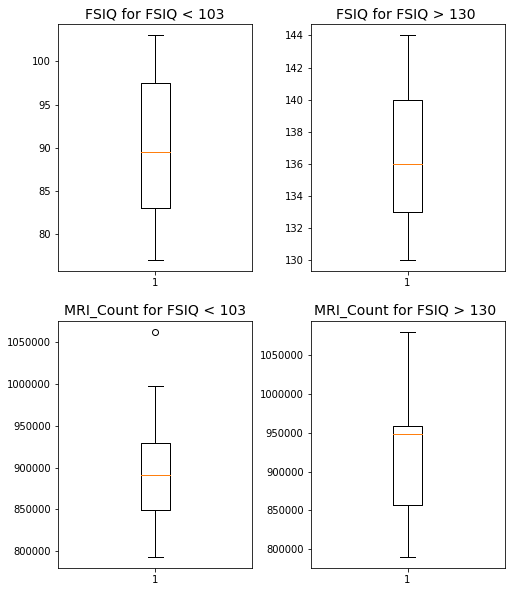

In [6]:
show_boxplots(both_sexes_less_103, both_sexes_more_130)

Выброс присутствует у переменной "MRI_Count" для подгруппы с меньшим уровнем интеллекта. Попробуем установить причину выброса

In [7]:
both_sexes_less_103.sort_values(['MRI_Count']).tail()

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
38,Male,81,90,74,148.0,74.0,930016
39,Male,89,91,89,179.0,75.5,935863
17,Male,100,96,102,178.0,73.5,945088
32,Male,103,96,110,192.0,75.5,997925
27,Male,103,96,110,187.0,77.0,1062462


Студент, размер мозга которого вышел за интерквартильное расстояние, по остальным параметрам ничем не выделяется среди других студентом с бОльшим размером мозга. Значит, для анализа этот студент будет выбросом. Поэтому выброс удаляем

In [8]:
both_sexes_less_103 = both_sexes_less_103.drop(27)

Попробуем проанализировать гистограммы распределений для инстересующих нас переменных. Для удобства так же напишем функцию для вывода распределений

In [9]:
def show_hists(less_103, more_130):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
    fs = 14

    variables = ['FSIQ', 'MRI_Count']

    for row in range(2):
        variable = variables[row]
        axes[row, 0].hist(less_103[variable],
                          density=True,
                          bins=math.ceil(1.72 *
                                         math.pow(less_103.shape[0], 1 / 3)))
        axes[row, 0].set_title(variable + ' for FSIQ < 103', fontsize=fs)

        axes[row, 1].hist(more_130[variable],
                          density=True,
                          bins=math.ceil(1.72 *
                                         math.pow(more_130.shape[0], 1 / 3)))
        axes[row, 1].set_title(variable + ' for FSIQ > 130 ', fontsize=fs)

    fig.subplots_adjust(wspace=0.6, hspace=0.2)
    plt.show()

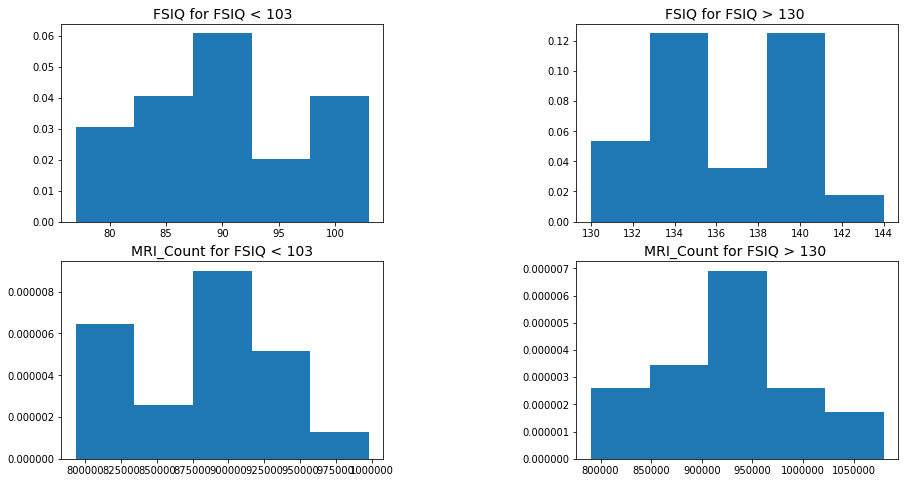

In [10]:
show_hists(both_sexes_less_103, both_sexes_more_130)

Гистограммы неоднородны, на трёх из четырёх графиков присутствует несколько пиков. Произошло это потому, что рассматриваются данные для студентов обоих полов одновременно. Если бы распределения у мужчин и женщин были бы одинаковыми, то распределения просто "наложились" бы друг на друга. Но на графиках мы видим будто смесь разных распределений.

При проверке гипотезы для коэффициента корреляции Пирсона предполагается, что распределения обеих величин нормальные. Проверим это.

Для удобства так же напишем функцию

In [11]:
#проверка данных на нормальность при помощи критерия Shapiro-Wilk
def show_normality(less_103, more_130):
    df_normality = pd.DataFrame(
        {
            'FSIQ for FSIQ<103': stats.shapiro(less_103["FSIQ"]),
            'FSIQ for FSIQ>130': stats.shapiro(more_130["FSIQ"]),
            'MRI_Count for FSIQ<103': stats.shapiro(less_103["MRI_Count"]),
            'MRI_Count for FSIQ>130': stats.shapiro(more_130["MRI_Count"])
        },
        index=['Test statistic', 'The p-value for the hypothesis test'])
    return df_normality

In [12]:
show_normality(both_sexes_less_103, both_sexes_more_130)

,FSIQ for FSIQ<103,FSIQ for FSIQ>130,MRI_Count for FSIQ<103,MRI_Count for FSIQ>130
Test statistic,0.956181,0.927217,0.972948,0.956478
The p-value for the hypothesis test,0.499707,0.136488,0.833488,0.476107


Ни одно из распределений не является нормальным при уровне значимости 5%

Построим диаграммы рассеяния. Возможно, на них будет видна линейная зависимость между исследуемыми переменными. Построение диаграмм также оформим в виде функции

In [13]:
def show_scatters(less_103, more_130):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
    fs = 14

    variables = ['FSIQ', 'MRI_Count']

    axes[0].scatter(less_103['FSIQ'], less_103['MRI_Count'])
    axes[0].set_title('FSIQ and MRI_Count for FSIQ<103')

    axes[1].scatter(more_130['FSIQ'], more_130['MRI_Count'])
    axes[1].set_title('FSIQ and MRI_Count for FSIQ>130')

    fig.subplots_adjust(wspace=0.6, hspace=0.2)
    plt.show()

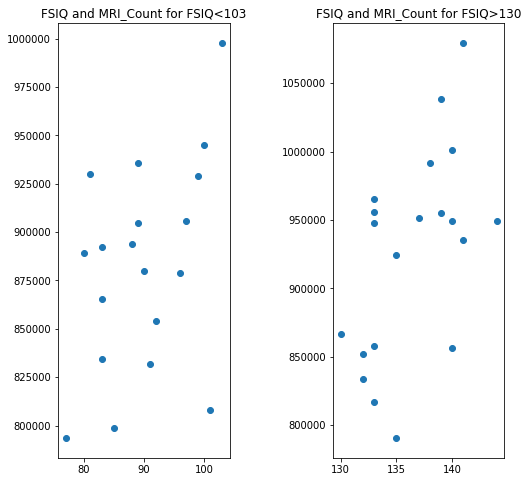

In [14]:
show_scatters(both_sexes_less_103, both_sexes_more_130)

Из диаграмм видно, что даже если линейная зависимость есть, то в ней всё равно присутствуют значительные отклонения. Тем не менее попробуем посчитать коэффициенты корреляции Пирсона

In [15]:
df_Pearson = pd.DataFrame(
    {
        'FSIQ and MRI_Count FSIQ<103':
        stats.pearsonr(both_sexes_less_103["FSIQ"],
                       both_sexes_less_103["MRI_Count"]),
        'FSIQ and MRI_Count FSIQ>130':
        stats.pearsonr(both_sexes_more_130["FSIQ"],
                       both_sexes_more_130["MRI_Count"])
    },
    index=['Pearson’s correlation coefficient', '2-tailed p-value'])
df_Pearson

,FSIQ and MRI_Count FSIQ<103,FSIQ and MRI_Count FSIQ>130
Pearson’s correlation coefficient,0.414856,0.548285
2-tailed p-value,0.077372,0.012314


Видим умеренную корреляцию у выборки из обоих полов с FSIQ$\leq$103. Эта корреляция статистически не значимая.

###### Корреляция у выборки с FSIQ$\geq$130 заметная и является статистически значимой. 

Так как распределения не нормальные, полагаться на коэффициент корреляции Пирсона опасно. Поэтому на всякий случай воспользуемся коэффициентом корреляции Спирмена.

In [16]:
df_Spearman = pd.DataFrame(
    {
        'FSIQ and MRI_Count FSIQ<103':
        stats.spearmanr(both_sexes_less_103["FSIQ"],
                        both_sexes_less_103["MRI_Count"]),
        'FSIQ and MRI_Count FSIQ>130':
        stats.spearmanr(both_sexes_more_130["FSIQ"],
                        both_sexes_more_130["MRI_Count"])
    },
    index=['Spearman’s correlation coefficient', '2-tailed p-value'])
df_Spearman

,FSIQ and MRI_Count FSIQ<103,FSIQ and MRI_Count FSIQ>130
Spearman’s correlation coefficient,0.328792,0.474191
2-tailed p-value,0.169303,0.034659


Результат почти такой же, как и при применении формулы Пирсона. Вывод остаётся тем же

## Sample containing men only

Разделим данные на две подгруппы:мужчины с общим уровнем интеллекта $\leq$ 103 и соответственно $\geq$ 130

In [17]:
both_sexes_less_103 = df_raw[df_raw['FSIQ'] <= 103]
both_sexes_more_130 = df_raw[df_raw['FSIQ'] >= 130]

men_less_103 = both_sexes_less_103[both_sexes_less_103['Gender'] == 'Male']
men_more_130 = both_sexes_more_130[both_sexes_more_130['Gender'] == 'Male']

Проверим данные на наличие выбросов. Проверка происходит по каждой переменной для обеих подгрупп

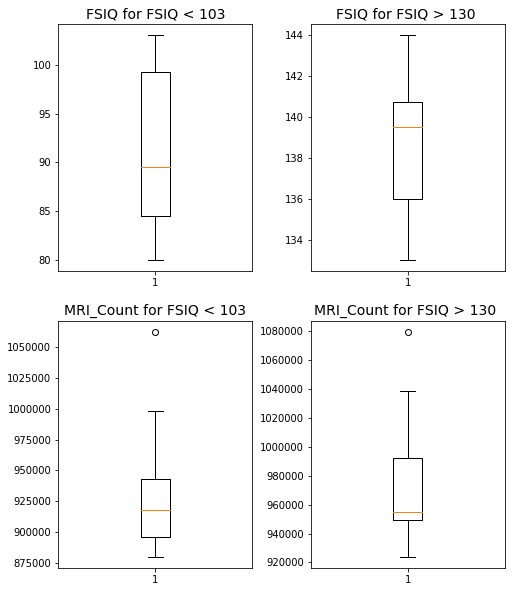

In [18]:
show_boxplots(men_less_103, men_more_130)

Выбросы присутствуют у переменной "MRI_Count" в обеих подгруппах. Отсекать их не будем, так как выборки и без того очень маленькие.

Попробуем проанализировать гистограммы распределений переменных

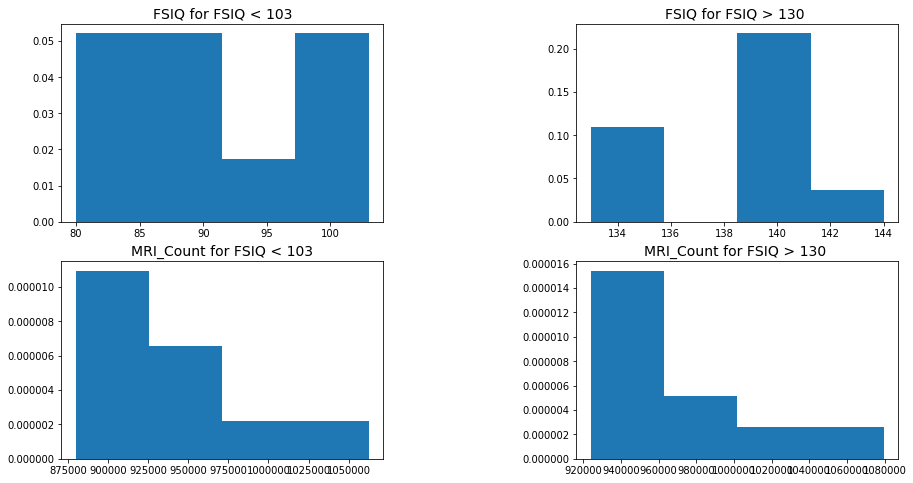

In [19]:
show_hists(men_less_103, men_more_130)

Снова распределения не напоминают нормальные. Проверим по критерию Шапиро-Вилк

In [20]:
show_normality(men_less_103, men_more_130)

,FSIQ for FSIQ<103,FSIQ for FSIQ>130,MRI_Count for FSIQ<103,MRI_Count for FSIQ>130
Test statistic,0.904474,0.896143,0.844282,0.843383
The p-value for the hypothesis test,0.245149,0.198636,0.049649,0.048436


Преобразование Бокса-Кокса и логарифмирование не дали результатов (здесь не приведены), поэтому в данном пункте имеем два нормальных распределения при уровне значимости 5%: MRI_Count для обеих подгрупп

Построим диаграммы рассеяния. Возможно, на них будет видна линейная зависимость между исследуюмыми переменными.

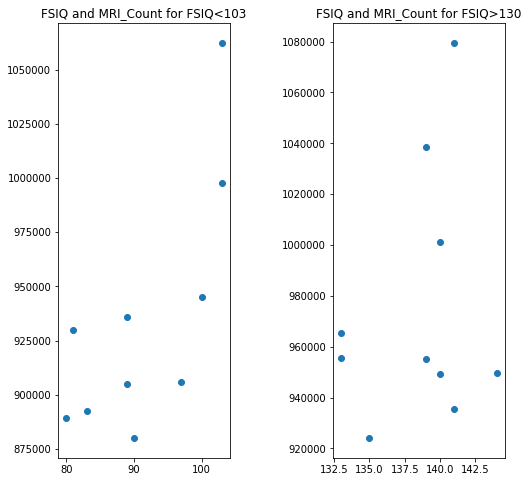

In [21]:
show_scatters(men_less_103, men_more_130)

Данных крайне мало, но некоторая линейность прослеживается в обеих группах

Попробуем посчитать коэффициенты корреляции Пирсона

In [22]:
df_Pearson = pd.DataFrame(
    {
        'FSIQ and MRI_Count FSIQ<103':
        stats.pearsonr(men_less_103["FSIQ"], men_less_103["MRI_Count"]),
        'FSIQ and MRI_Count FSIQ>130':
        stats.pearsonr(men_more_130["FSIQ"], men_more_130["MRI_Count"])
    },
    index=['Pearson’s correlation coefficient', '2-tailed p-value'])
df_Pearson

,FSIQ and MRI_Count FSIQ<103,FSIQ and MRI_Count FSIQ>130
Pearson’s correlation coefficient,0.714624,0.236100
2-tailed p-value,0.020213,0.511372


###### В данном пункте заметна высокая корреляция между размером мозга и интеллектом у группы мужчин с уровнем интеллекта$\leq$103.

Значения коэффициентов достаточно хорошо выражены, поэтому применять другие критерии корреляции не будем.

## ## Sample containing women only

Разделим данные на две подгруппы:женщины с общим уровнем интеллекта $\leq$ 103 и соответственно $\geq$ 130

In [23]:
both_sexes_less_103 = df_raw[df_raw['FSIQ'] <= 103]
both_sexes_more_130 = df_raw[df_raw['FSIQ'] >= 130]

women_less_103 = both_sexes_less_103[both_sexes_less_103['Gender'] == 'Female']
women_more_130 = both_sexes_more_130[both_sexes_more_130['Gender'] == 'Female']

Проверим данные на наличие выбросов. Проверка происходит по каждой переменной для обеих групп

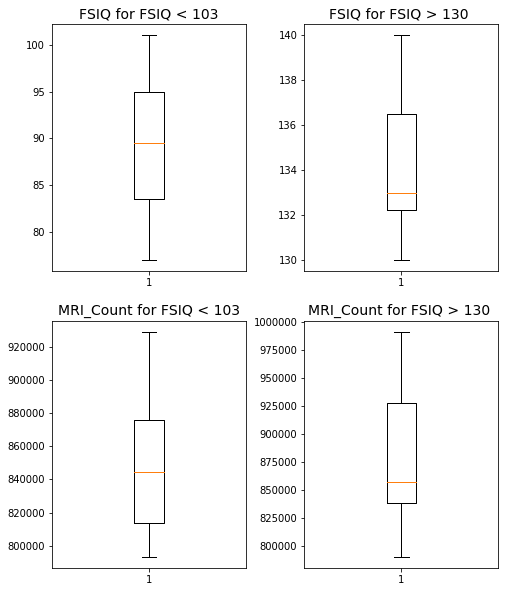

In [24]:
show_boxplots(women_less_103, women_more_130)

Выбросов нет. Попробуем проанализировать гистограммы распределений переменных

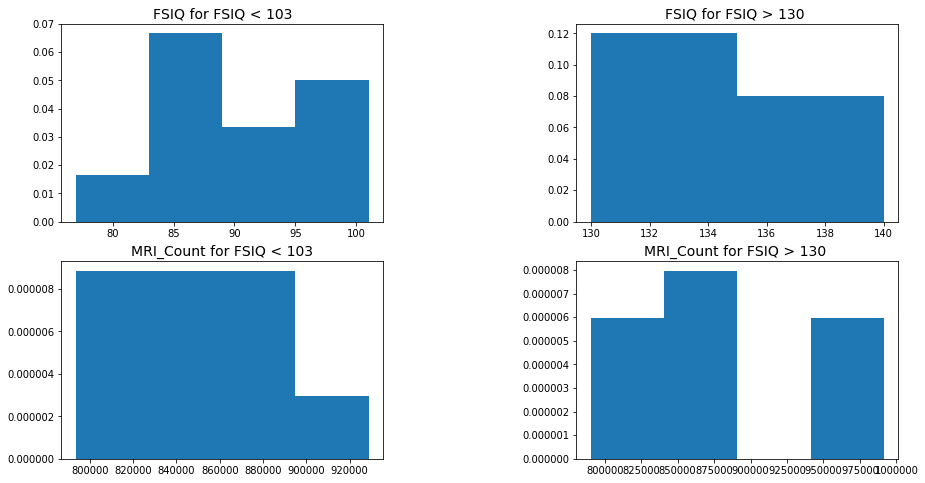

In [25]:
show_hists(women_less_103, women_more_130)

И опять распределения не напоминают нормальные. Проверим по критерию Шапиро-Вилк

In [26]:
show_normality(women_less_103, women_more_130)

,FSIQ for FSIQ<103,FSIQ for FSIQ>130,MRI_Count for FSIQ<103,MRI_Count for FSIQ>130
Test statistic,0.968863,0.925200,0.958474,0.905037
The p-value for the hypothesis test,0.880107,0.402367,0.768347,0.248606


В данном пункте нет ни одного нормального распределения, будем учитывать это при использовании коэффициента Пирсона. Построим диаграммы рассеяния. 

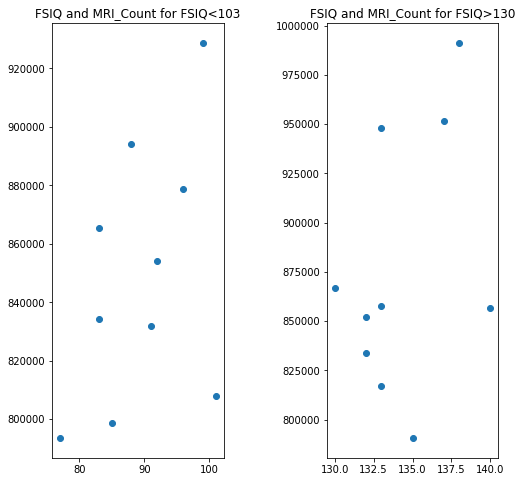

In [27]:
show_scatters(women_less_103, women_more_130)

На обоих графика прослеживается очень слабая линейность

Попробуем посчитать коэффициенты корреляции Пирсона

In [28]:
df_Pearson = pd.DataFrame(
    {
        'FSIQ and MRI_Count FSIQ<103':
        stats.pearsonr(women_less_103["FSIQ"], women_less_103["MRI_Count"]),
        'FSIQ and MRI_Count FSIQ>130':
        stats.pearsonr(women_more_130["FSIQ"], women_more_130["MRI_Count"])
    },
    index=['Pearson’s correlation coefficient', '2-tailed p-value'])
df_Pearson

,FSIQ and MRI_Count FSIQ<103,FSIQ and MRI_Count FSIQ>130
Pearson’s correlation coefficient,0.428870,0.359098
2-tailed p-value,0.216192,0.308171


Ни одна пара не имеет статистически значимой корреляции. Но распределения не нормальные, поэтому попробуем воспользоваться коэффициентом корреляции Спирмена.

In [29]:
df_Spearman = pd.DataFrame(
    {
        'FSIQ and MRI_Count FSIQ<103':
        stats.spearmanr(women_less_103["FSIQ"], women_less_103["MRI_Count"]),
        'FSIQ and MRI_Count FSIQ>130':
        stats.spearmanr(women_more_130["FSIQ"], women_more_130["MRI_Count"])
    },
    index=['Spearman’s correlation coefficient', '2-tailed p-value'])
df_Spearman

,FSIQ and MRI_Count FSIQ<103,FSIQ and MRI_Count FSIQ>130
Spearman’s correlation coefficient,0.382980,0.258492
2-tailed p-value,0.274673,0.470840


У женщин статистически значимых корреляций между уровнем интеллекта и размером мозга не наблюдается

# Conclusion

Статистически значимые корреляции между размером мозга и уровнем интеллекта были обнаружены у выборки из обоих полов с FSIQ$\geq$130, а также у группы мужчин с уровнем интеллекта$\leq$103.  